# Анализ лояльности пользователей Яндекс Афиши
Автор: Константин Касьянов  
19.10.2025

## Цель и задачи проекта

Цель проекта - провести исследовательский анализ поведения пользователей платформы, чтобы определить факторы, влияющие на возврат клиентов и совершение повторных заказов.

Результаты исследования помогут маркетинговой команде:

- быстро выявлять перспективных клиентов и предлагать им персонализированные условия;

- точнее настраивать рекламные кампании на аудитории с высокой вероятностью возврата;

- оптимизировать использование маркетингового бюджета;

- повысить общий уровень удержания клиентов.

Задачи

- Загрузить и изучить данные, предоставленные платформой.

- Провести предобработку данных и подготовить их к анализу.
  
- Создать профиль пользователя.

- Провести исследовательский анализ поведения пользователей:

    - исследовать признаки первого заказа и их связи с возвращением на платформу;

    - исследовать поведение пользователей через показатели выручки и состава заказа;

    - исследовать временные характеристики первого заказа и их влияния на повторные покупки;

    - провести корреляционный анализ количества покупок и признаков пользователя

- Сформулировать выводы и рекомендации по повышению удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Пункт 1.1:** Напишем SQL-запрос, выгружающий в датафрейм pandas необходимые данные.


Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
#!pip install dotenv
#!pip install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine 
from dotenv import load_dotenv
from os import getenv
import ast

try:
    load_dotenv(dotenv_path="secret.env")
    db_config_str = getenv("DB_CONFIG")
    db_config = ast.literal_eval(db_config_str)
except Exception:
    print("Ошибка доступа, у вас нет файла-ключа")


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)
with engine.connect() as connection:
    query = """WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT user_id,device_type_canonical,order_id,created_dt_msk AS order_dt,created_ts_msk AS order_ts,currency_code,revenue,tickets_count, CASE WHEN LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk) IS NULL THEN NULL ELSE  EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))) END AS days_since_prev, event_id, event_name_code AS event_name, event_type_main, service_name, region_name, city_name
FROM afisha.purchases
LEFT JOIN afisha.events USING(event_id)
LEFT JOIN afisha.city USING(city_id)
LEFT JOIN afisha.regions USING(region_id)
WHERE (device_type_canonical IN ('mobile', 'desktop')) AND (event_type_main != 'фильм')
ORDER BY user_id"""
    df = pd.read_sql(query, connection)

---

**Пункт 1.2:** Изучим общую информацию о выгруженных данных. Оценим корректность выгрузки и объём полученных данных.

---

In [3]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [5]:
df.shape

(290611, 15)

### Промежуточный вывод по главе 1
Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о бронировании билетов Яндекс.Афиша. После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов корректны (snake case)
- Данные содержат текстовые данные (object), числовые значения (хранятся в типах данных int64 или float64), даты (datetime64). Все типы данных корректны (`days_since_prev` - это целые числа + NaN, но замена NaN на заглушку будет мешать дальнейшему анализу важного столбца). Есть возможность оптимизировать разрядность хранения.
- Пропуски есть в days_since_prev у клиентов, которые совершили только 1 заказ.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

###  2. Предобработка данных

Выполним все стандартные действия по предобработке данных:

---

**Пункт 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведём выручку к единой валюте — российскому рублю.

Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. 

Результаты преобразования сохраним в новый столбец `revenue_rub`.

---


In [6]:
#сделаем копию датафрейма для анализа
df_copy = df.copy()

In [7]:
exchange_rates = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
exchange_rates.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
exchange_rates['data'] = pd.to_datetime(exchange_rates['data'])
display(min(exchange_rates['data']), max(exchange_rates['data']))
display(min(df['order_dt']), max(df['order_dt']))

Timestamp('2024-01-10 00:00:00')

Timestamp('2024-12-31 00:00:00')

Timestamp('2024-06-01 00:00:00')

Timestamp('2024-10-31 00:00:00')

In [9]:
def convert_currency(row):
    if row['currency_code'] == 'kzt':
        rate = exchange_rates.loc[exchange_rates['data'] == row['order_dt']]['curs'].values[0]
        return row['revenue'] * rate / 100
    else:
        return row['revenue']
    
df['revenue_rub'] = df.apply(convert_currency, axis=1)
df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


Пересчитали по курсу покупки в тенге, теперь у всех строк, в независимости от валюты покупки, есть стоимость в колонке `revenue_rub`.

---

**Пункт 2.2:**

- Проверим данные на пропущенные значения.
- Преобразуем типы данных в некоторых столбцах.
- Изучим значения в ключевых столбцах и обработаем, при наличии, ошибки.
    - Проверим, какие категории указаны в столбцах с номинальными данными и проведем, при необходимости, нормализацию данных.
    - Проверим распределение численных данных и наличие в них выбросов через статистические показатели, гистограммы распределения значений или диаграммы размаха.

---

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Пропуски только в `days_since_prev`. Проведем оптимизацию


In [11]:
#округлим до копеек
df['revenue'] = df['revenue'].round(2)
df['revenue_rub'] = df['revenue_rub'].round(2)
for int_col in ['order_id', 'tickets_count', 'event_id']:
    df[int_col] = pd.to_numeric(df[int_col], downcast='integer')
for float_col in ['revenue', 'revenue_rub', 'days_since_prev']:
    df[float_col] = pd.to_numeric(df[float_col], downcast='float')
df['order_dt'] = df['order_dt'].dt.normalize()
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [12]:
pd.DataFrame({'amount':df.isna().sum(),'share':df.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,0,0.000000
days_since_prev,21933,0.075472
event_id,0,0.000000


In [13]:
df.duplicated().sum()

np.int64(0)

Проверим на скрытые дубликаты и ошибки.

In [14]:
for column in ['event_name', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    display(f'Уникальные значения в столбце {column}:')
    display(df[column].sort_values().unique())

'Уникальные значения в столбце event_name:'

array(['000a9c8d-65bb-4178-a5a8-9ddc1f3bf71e',
       '0015b11d-a3e0-4656-887a-383450a9b313',
       '00298e1a-ae90-482b-819d-ba88ceff59b0', ...,
       'fff20f2b-de72-451a-8168-b765352e502c',
       'fff68929-41eb-4dd7-90bf-76d3ae8b652f',
       'fffd87ef-5469-4684-af21-4f9b86a13189'],
      shape=(15248,), dtype=object)

'Уникальные значения в столбце event_type_main:'

array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

'Уникальные значения в столбце service_name:'

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

'Уникальные значения в столбце region_name:'

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

'Уникальные значения в столбце city_name:'

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

Видим "другое" в `event_type_main`. Изучим подробнее:

In [15]:
df.groupby('event_type_main')['order_id'].count().sort_values(ascending=False)

event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: order_id, dtype: int64

Строк с данным типом ("другое") очень много. Посмотрим, с какими описаниями событий связан данный тип в базе.

In [16]:
with create_engine(connection_string, pool_pre_ping=True).connect() as connection:
    query = """WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT event_type_description, COUNT(*) AS amount
FROM afisha.purchases
LEFT JOIN afisha.events USING(event_id)
WHERE event_type_main = 'другое'
GROUP BY event_type_description
order by COUNT(*) DESC"""
    others = pd.read_sql(query, connection)
display(others)

,event_type_description,amount
0,событие,53905
1,выставка,5890
2,цирковое шоу,5248
3,шоу,890
4,музыкальный спектакль,140
5,кукольный спектакль,13
6,экскурсия,8
7,оперетта,7
8,подарок,4
9,снегурочка,3


In [17]:
display(others[others['event_type_description']=='событие']['amount']/df.shape[0]*100)
display(others['amount'].sum()/df.shape[0]*100)

0    18.548851
Name: amount, dtype: float64

np.float64(22.748278626755354)

Таким образом, мы получили 65867 событий (23% от всего массива) из категории другое, из которых 53905 событий с описанием "событие". Далее мы будем проводить аналитику в зависимости от типа первого события, поэтому пока предлагается эти данные не удалять.  
Посмотрим на распределение прибыли с заказа.

In [18]:
df['revenue_rub'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])



count    290611.000000
mean        555.571989
std         875.498170
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
95%        1630.650000
99%        2628.420000
max       81174.540000
Name: revenue_rub, dtype: float64

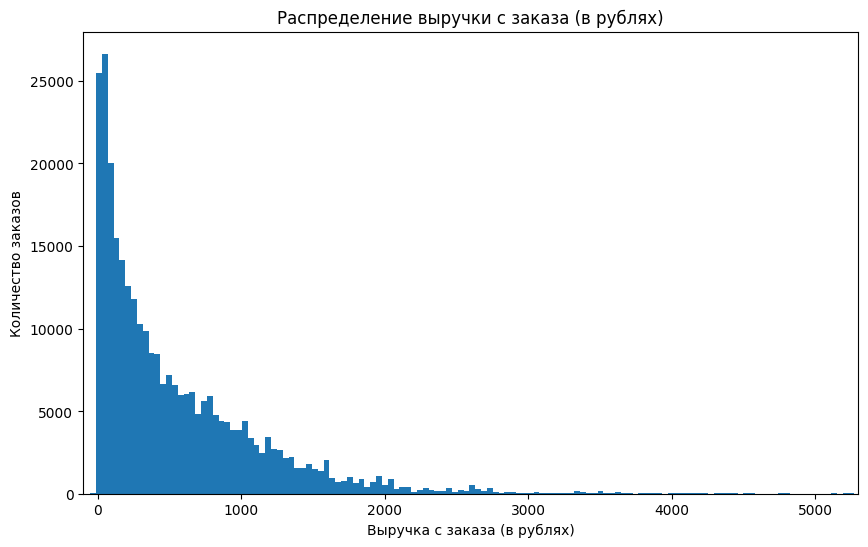

In [19]:
plt.figure(figsize=(10,6))
df['revenue_rub'].plot(kind='hist', bins=2000, xlim=(-100, 5300))
plt.title('Распределение выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.ylabel('Количество заказов')
plt.show()

Максимальное значение выручки 81174.54, что боллее, чем десятикратно выше 99-го перцентиля (2628.42). Отфильтруем, также удалим ошибочные отрицательные значения, посмотрим заново на гистограмму и построим диаграмму размаха.

In [20]:
percentile_99_rev = df['revenue_rub'].quantile(0.99)
def procentile_filter(row):
    if (row['revenue_rub'] > percentile_99_rev) or (row['revenue_rub'] < 0):
        return np.nan
    else:
        return row['revenue_rub']
    
df['revenue_rub'] = df.apply(procentile_filter, axis=1)
df['revenue_rub'].describe()

count    287405.000000
mean        518.719259
std         511.951843
min           0.000000
25%         112.600000
50%         344.830000
75%         788.900000
max        2628.420000
Name: revenue_rub, dtype: float64

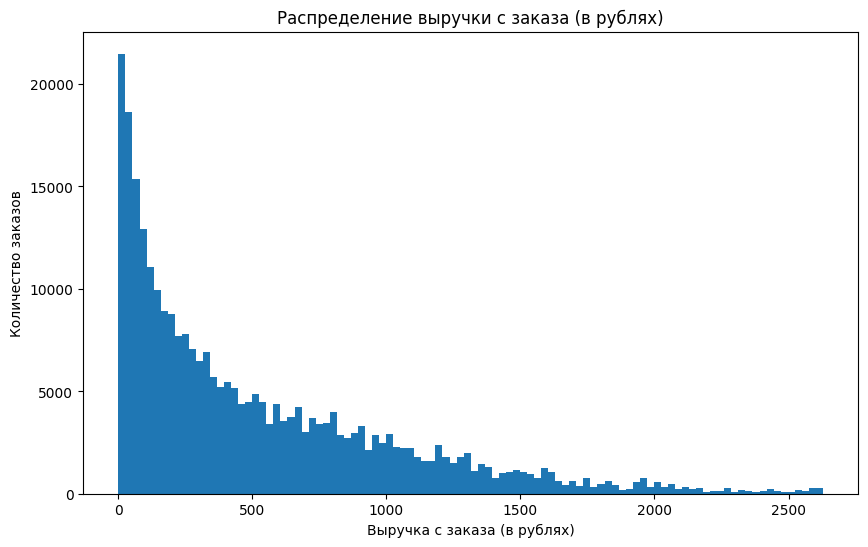

In [21]:
plt.figure(figsize=(10,6))
df['revenue_rub'].plot(kind='hist', bins=100)
plt.title('Распределение выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.ylabel('Количество заказов')
plt.show()

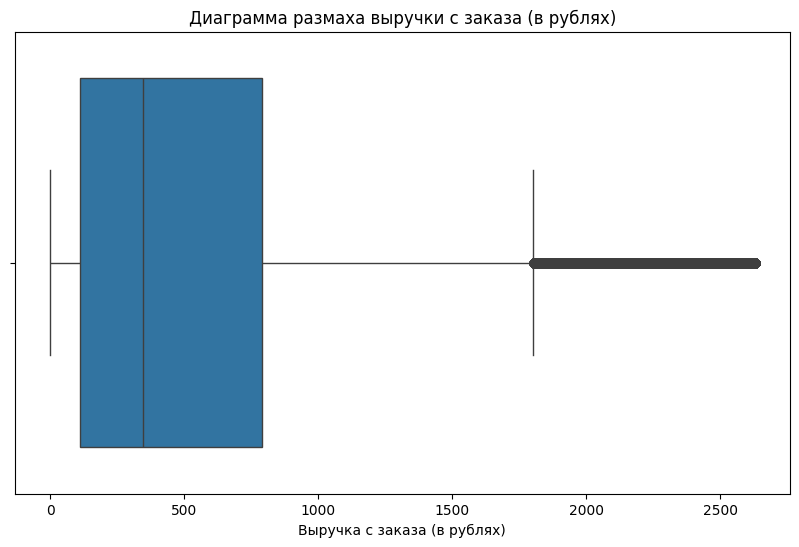

In [22]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['revenue_rub'])
plt.title('Диаграмма размаха выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.show()

После удаления выбросов видим правое ассиметричное распределение выручки с заказов(среднее 518, медиана 345), медиана значительно ниже среднего значения. Диаграмма размаха показывает выбросы, но на гистограмме видно плавное падение количества заказов с увеличением выручки.  
Далее оценим количество билетов в заказе.

In [23]:
df['tickets_count'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

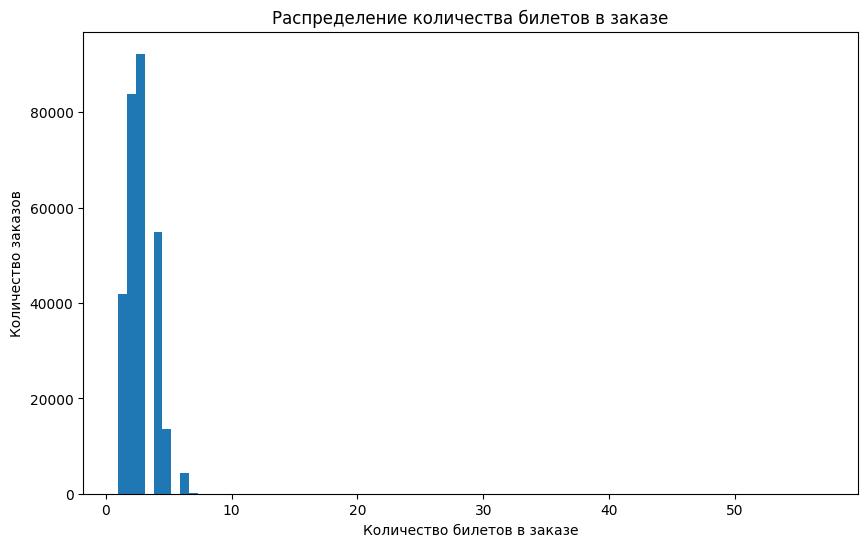

In [24]:
plt.figure(figsize=(10,6))
df['tickets_count'].plot(kind='hist', bins=80)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')   
plt.ylabel('Количество заказов')
plt.show()

Снова похожая картина: максимум 57 билетов на заказ, что почти в 10 раз выше 99-го перцентиля (6). Отфильтруем заказы с количеством билетов больше 6 и посмотрим на гистограмму и диаграмму размаха.

In [25]:
percentile_99_rev = df['tickets_count'].quantile(0.99)
def procentile_filter(row):
    if row['tickets_count'] > percentile_99_rev:
        return np.nan
    else:
        return row['tickets_count']
    
df['tickets_count'] = df.apply(procentile_filter, axis=1)
df['tickets_count'].describe()

count    290423.000000
mean          2.749366
std           1.143899
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

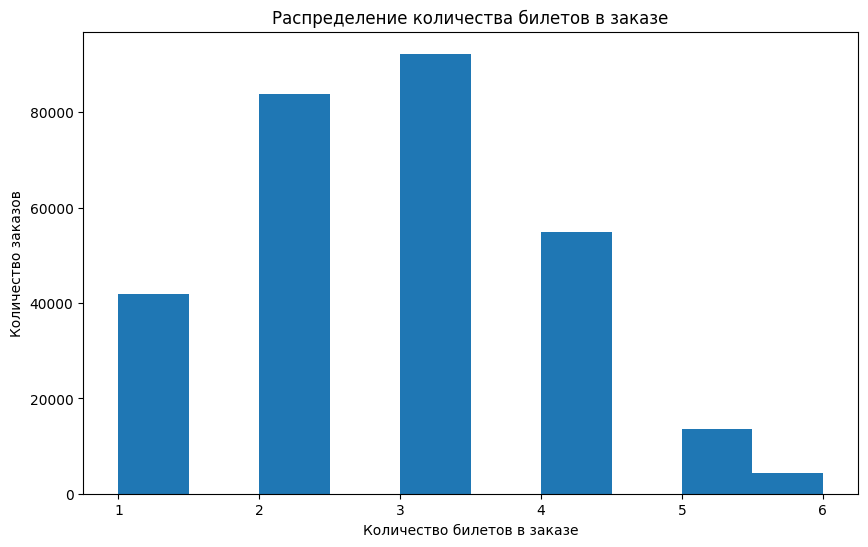

In [26]:
plt.figure(figsize=(10,6))
df['tickets_count'].plot(kind='hist')
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.show()

После удаления выбросов в количестве билетов в заказе видим незначительно правое ассимметричное распределение (среднее 2.75, медиана 3.0).  
Далее `days_since_prev`:

In [27]:
df['days_since_prev'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

count    268678.000000
mean          3.222381
std          11.350510
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
95%          18.000000
99%          63.000000
max         148.000000
Name: days_since_prev, dtype: float64

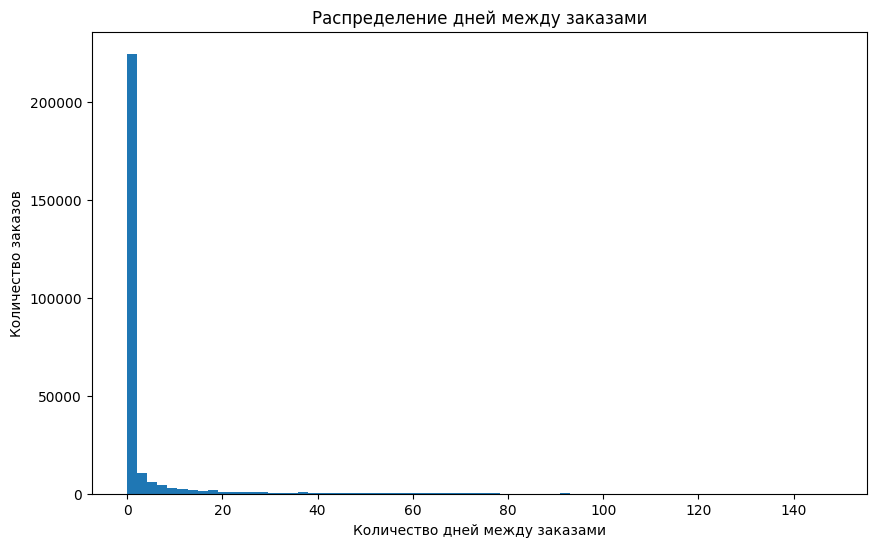

In [28]:
plt.figure(figsize=(10,6))
df['days_since_prev'].plot(kind='hist', bins=70)
plt.title('Распределение дней между заказами')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Количество заказов')
plt.show()

In [29]:
df_test = df.groupby('user_id').agg({
    'order_id': 'nunique','event_id': 'nunique','days_since_prev': 'mean'}).sort_values(by='user_id')
df_test_filtered = df_test.loc[df_test['order_id'] > df_test['event_id']]
display(df_test_filtered)
display(df_test.shape)
display(df_test_filtered.shape)

,order_id,event_id,days_since_prev
user_id,,,
000cf0659a9f40f,13,1,0.083333
00147c9209d45d3,2,1,0.000000
0020c5654c92ec1,2,1,0.000000
002b75ca606ba46,6,5,20.000000
002ec276eee9b0b,22,13,5.380952
...,...,...,...
ffe73c50cbd71fc,2,1,0.000000
ffecf05f1f6a9c6,4,3,20.000000
ffed3ff067d4f12,4,3,26.000000


(21933, 3)

(10136, 3)

В распределении дней между заказами много значений 0, при этом таблица выше показывает, что половина пользователей покупала билеты на одно и то же мероприятие отдельными заказами. В дальнейшем рекомендуется данные обработать отдельно и принять решение о возможности слияния. Распределение остается без изменений:

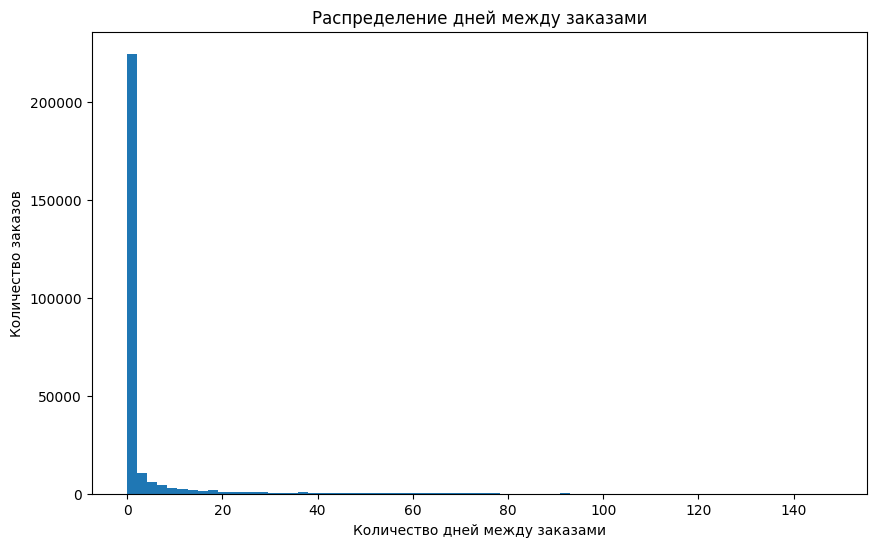

In [30]:
#df['days_since_prev'] = df['days_since_prev'].replace(0, np.nan)
plt.figure(figsize=(10,6))
df['days_since_prev'].plot(kind='hist', bins=70)
plt.title('Распределение дней между заказами')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Количество заказов')
plt.show()

In [31]:
pd.DataFrame({'amount':df.isna().sum(),'share':df.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,188,0.000647
days_since_prev,21933,0.075472
event_id,0,0.000000


In [32]:
pd.DataFrame({'amount':df_copy.isna().sum(),'share':df_copy.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,0,0.000000
days_since_prev,21933,0.075472
event_id,0,0.000000


In [33]:
days_del = pd.DataFrame({'amount':df.isna().sum(),'share':df.isna().mean()}).loc['days_since_prev','amount'] - pd.DataFrame({'amount':df_copy.isna().sum(),'share':df_copy.isna().mean()}).loc['days_since_prev','amount']
display(f"Количество удалённых значений в days_since_prev: {days_del}")
display(f" Процент удаленных значений {round(days_del / df_copy['days_since_prev'].count() * 100)} %")

'Количество удалённых значений в days_since_prev: 0'

' Процент удаленных значений 0 %'

### Промежуточный вывод по главе 2
- Добавили `revenue_rub` - прибыль с заказа в рублях.
- Пропуски есть только в столбце `days_since_prev`.
- Оптимизировали размерность столбцов:`order_id` - int64 -> int32, `tickets_count` - int64 -> int16, `event_id` - int64 -> int32, `revenue` - float64 -> float32, `revenue_rub` - float64 -> float32, `days_since_prev` - float64 -> float32. В датах нормализировали столбец `order_dt`
- Изучили значения в ключевых столбцах.
    - Среди категорий в столбцах с номинальными данными не таких, что обозначают пропуски в данных или отсутствие информации
    - Отфильтровали значения в `revenue_rub` и `tickets_count` по 99 перцентилю.
    - Удалили записи 0 дней в `days_since_prev`, которые связаны с дроблением покупки на одно мероприятие на несколько заказов. Такие случаи не отражают поведение возвращающихся пользователей и искажают распределение.

Всего было удалено 188 значений в `tickets_count` (0.07% от общего числа), 3206 значений в `revenue_rub` (1.1%)

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Построим для них агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Пункт 3.1.** Построим профиль пользователя — для каждого пользователя найдем:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


---


In [34]:
df_profile = df.sort_values(by=['user_id','order_ts']).groupby('user_id').agg(first_order_dt=('order_dt','first'), last_order_dt=('order_dt','last'), device=('device_type_canonical','first'),region=('region_name','first'), 
                                                                              service=('service_name','first'), genre=('event_type_main','first'),total_orders=('order_id','nunique'), avg_revenue_per_order=('revenue_rub','mean'), 
                                                                              avg_tickets=('tickets_count','mean'), avg_days_between_orders=('days_since_prev','mean'))
df_profile.reset_index(inplace=True)
df_profile['is_two'] = df_profile['total_orders'].apply(lambda x: 1 if x>=2 else 0)
df_profile['is_five'] = df_profile['total_orders'].apply(lambda x: 1 if x>=5 else 0)
display(df_profile.head())
df_profile_copy = df_profile.copy()

,user_id,first_order_dt,last_order_dt,device,region,service,genre,total_orders,avg_revenue_per_order,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


Построили профиль пользователей с основными характеристиками и признаками лояльности в датафрейме df_profile.


- `first_order_dt` дата первого заказа;
- `last_order_dt` дата последнего заказа;
- `device` устройство, с которого был сделан первый заказ;
- `region` регион, в котором был сделан первый заказ;
- `service` билетного партнёра, к которому обращались при первом заказе;
- `genre` жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- `total_orders` общее количество заказов;
- `avg_revenue_per_order` средняя выручка с одного заказа в рублях;
- `avg_tickets` среднее количество билетов в заказе;
- `avg_days_between_orders` среднее время между заказами.
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


---

**Пункт 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными мы работаем: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оценим данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов.

При наличии аномальных значений, опишем их и примем обоснованное решение о том, как с ними поступить.

In [35]:
#число уникальных пользователей
display(df_profile.shape[0])
#средняя выручка на заказ
display(float(df_profile['avg_revenue_per_order'].mean()))
# доля пользователей, совершивших 2 и более заказа
display(f"{df_profile['is_two'].mean() * 100:.2f}%")
# доля пользователей, совершивших 5 и более заказов
display(f"{df_profile['is_five'].mean() * 100:.2f}%")

21933

545.0328015670657

'61.82%'

'29.18%'

In [36]:
df_profile[['total_orders','avg_tickets','avg_days_between_orders']].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,total_orders,avg_tickets,avg_days_between_orders
count,21933.000000,21924.000000,13559.000000
mean,13.249943,2.751419,15.808537
std,122.470535,0.907977,22.249582
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.757464,8.000000
75%,5.000000,3.125000,20.400000
95%,32.000000,4.000000,61.000000
99%,152.000000,5.000000,112.000000
max,10251.000000,6.000000,148.000000


У столбца `total_orders` максимум 10 251 заказ, что явно некорректно. Построим гистограммы для 95 и 99 процентилей и решим, как фильтровать данные. После проведем аналогичные действия по столбцу `avg_days_between_orders`. Столбец `avg_tickets` был отфильтрован ранее.

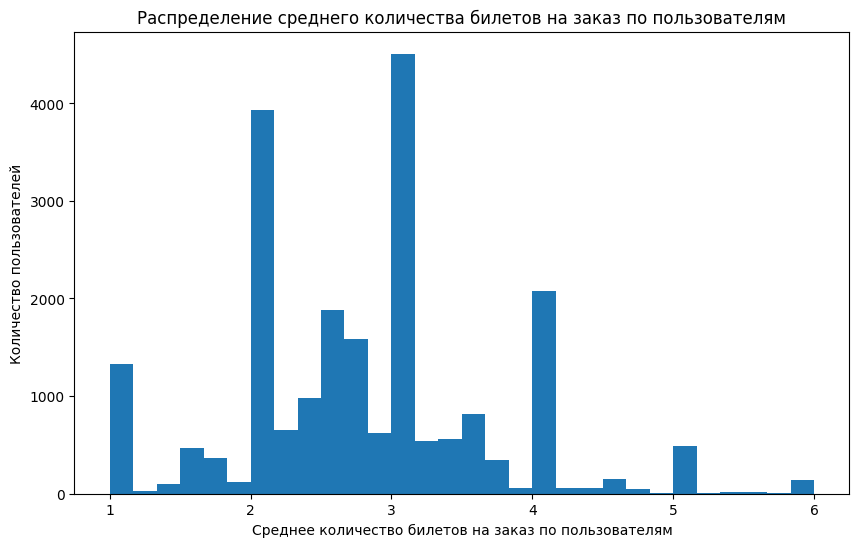

In [37]:
plt.figure(figsize=(10,6))
df_profile['avg_tickets'].plot(kind='hist', bins=30)
plt.title('Распределение среднего количества билетов на заказ по пользователям')
plt.xlabel('Среднее количество билетов на заказ по пользователям')
plt.ylabel('Количество пользователей')
plt.show()

In [38]:
order_95_percentile = df_profile['total_orders'].quantile(0.95)
order_99_percentile = df_profile['total_orders'].quantile(0.99)
day_95_percentile = df_profile['avg_days_between_orders'].quantile(0.95)
day_99_percentile = df_profile['avg_days_between_orders'].quantile(0.99)

order_95 = df_profile[df_profile['total_orders'] <= order_95_percentile]['total_orders']
order_99 = df_profile[df_profile['total_orders'] <= order_99_percentile]['total_orders']
day_95 = df_profile[df_profile['avg_days_between_orders'] <= day_95_percentile]['avg_days_between_orders']
day_99 = df_profile[df_profile['avg_days_between_orders'] <= day_99_percentile]['avg_days_between_orders']
display('order_95',order_95.describe(),'order_99', order_99.describe(),'day_95', day_95.describe(),'day_99', day_99.describe())



'order_95'

count    20864.000000
mean         4.108081
std          5.239384
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         32.000000
Name: total_orders, dtype: float64

'order_99'

count    21714.000000
mean         6.521691
std         14.335979
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

'day_95'

count    12884.000000
mean        11.891799
std         13.603739
min          0.000000
25%          0.845598
50%          7.333333
75%         17.750000
max         61.000000
Name: avg_days_between_orders, dtype: float64

'day_99'

count    13424.000000
mean        14.691592
std         19.335800
min          0.000000
25%          1.000000
50%          8.000000
75%         20.000000
max        112.000000
Name: avg_days_between_orders, dtype: float64

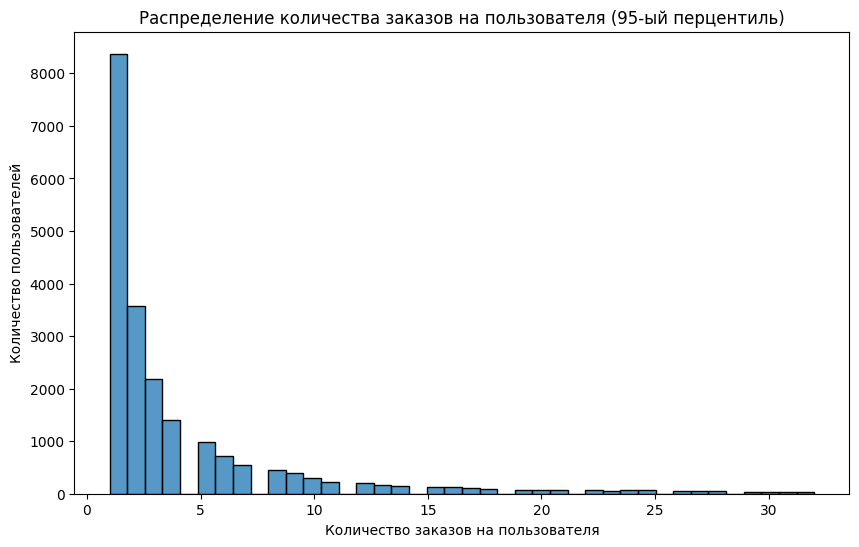

In [39]:
plt.figure(figsize=(10,6))
sns.histplot(data=order_95, bins=40, kde=False)
plt.title('Распределение количества заказов на пользователя (95-ый перцентиль)')
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

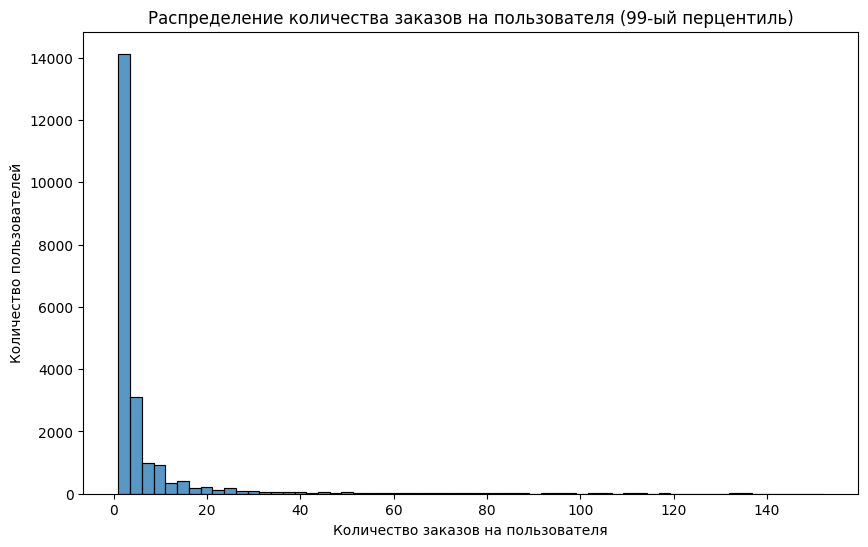

In [40]:
plt.figure(figsize=(10,6))
sns.histplot(data=order_99, bins=60, kde=False)
plt.title('Распределение количества заказов на пользователя (99-ый перцентиль)')
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Гистограмма для 99 перцентиля показывает, что количество клиентов с заказами более 30 штук на человека незначительно по сравнению с блоком до 30 заказов. Более того, он сильно искажают средние значения и делает распределения менее интерпретируемыми.  Для анализа «типичного» поведения клиентов (основная масса) лучше подойдет фильтрация по 95 перцентилю.  
  
Теперь к распределению количества дней между заказами.

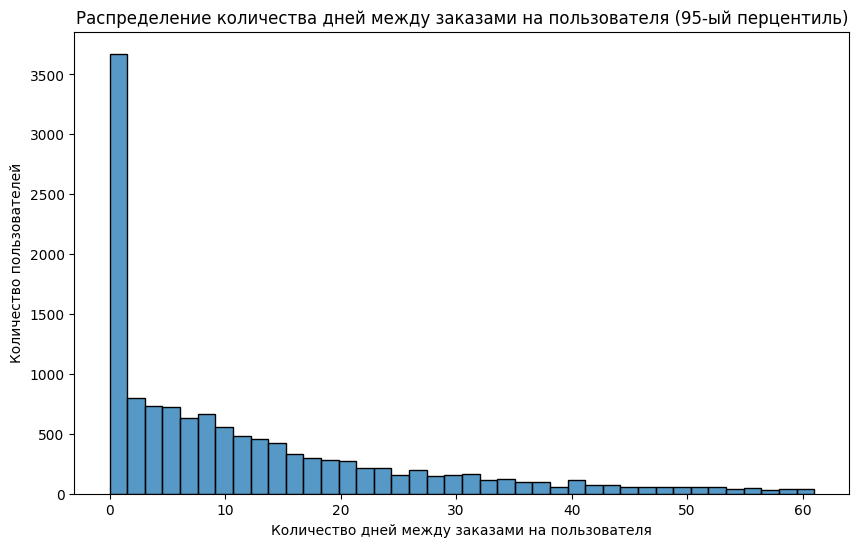

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(data=day_95, bins=40, kde=False)
plt.title('Распределение количества дней между заказами на пользователя (95-ый перцентиль)')
plt.xlabel('Количество дней между заказами на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

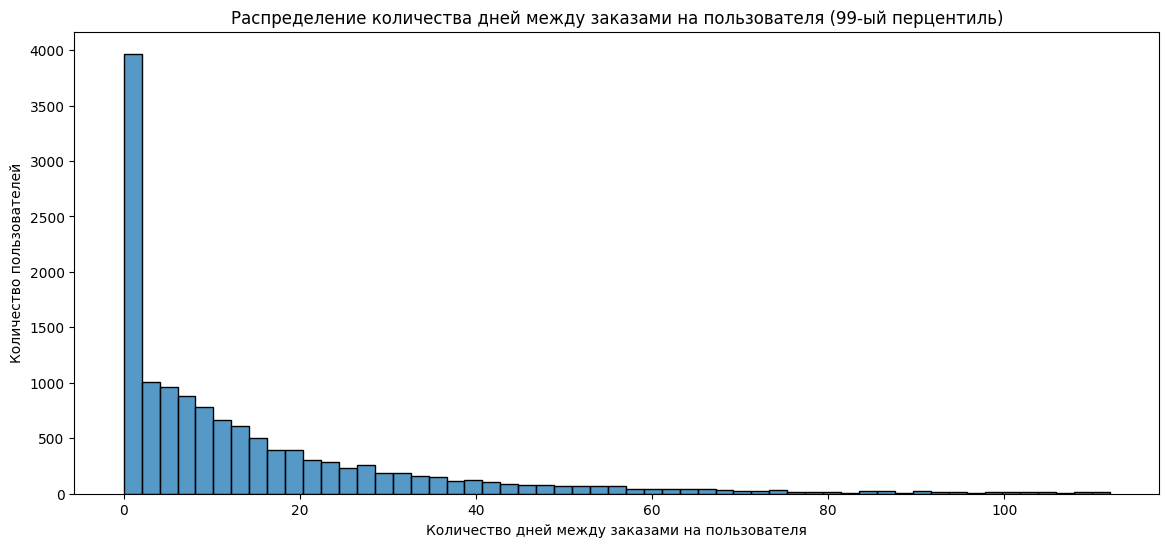

In [42]:
plt.figure(figsize=(14,6))
sns.histplot(data=day_99, bins=55, kde=False)
plt.title('Распределение количества дней между заказами на пользователя (99-ый перцентиль)')
plt.xlabel('Количество дней между заказами на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Здесь выводы аналогичные, для анализа «типичного» поведения клиентов (основная масса) лучше подойдет фильтрация по 95 перцентилю.  

In [43]:
# фильтруем датафрейм по 95 перцентилю

def percentile_filter_task_3(row, percentile):
    if row > percentile:
        return np.nan
    else:
        return row
    
df_profile['total_orders'] = df_profile['total_orders'].apply(percentile_filter_task_3, args=(order_95_percentile,))
df_profile['avg_days_between_orders'] = df_profile['avg_days_between_orders'].apply(percentile_filter_task_3, args=(day_95_percentile,))

In [44]:
display('До фильтрации:')
display(df_profile_copy[['total_orders','avg_tickets','avg_days_between_orders']].describe())
display('После фильтрации:')
display(df_profile[['total_orders','avg_tickets','avg_days_between_orders']].describe())

'До фильтрации:'

,total_orders,avg_tickets,avg_days_between_orders
count,21933.000000,21924.000000,13559.000000
mean,13.249943,2.751419,15.808537
std,122.470535,0.907977,22.249582
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.757464,8.000000
75%,5.000000,3.125000,20.400000
max,10251.000000,6.000000,148.000000


'После фильтрации:'

,total_orders,avg_tickets,avg_days_between_orders
count,20864.000000,21924.000000,12884.000000
mean,4.108081,2.751419,11.891800
std,5.239384,0.907977,13.603738
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,0.845598
50%,2.000000,2.757464,7.333333
75%,5.000000,3.125000,17.750000
max,32.000000,6.000000,61.000000


In [45]:
display("До фильтрации:")
task_3_1 = pd.DataFrame({'amount':df_profile_copy.isna().sum(),'share':df_profile_copy.isna().mean()})
display(task_3_1)
display("После фильтрации:")
task_3_2 = pd.DataFrame({'amount':df_profile.isna().sum(),'share':df_profile.isna().mean()})
display(task_3_2)
display(task_3_2.loc['avg_days_between_orders', 'amount'] - task_3_1.loc['avg_days_between_orders', 'amount'])

'До фильтрации:'

,amount,share
user_id,0,0.000000
first_order_dt,0,0.000000
last_order_dt,0,0.000000
device,0,0.000000
region,0,0.000000
service,0,0.000000
genre,0,0.000000
total_orders,0,0.000000
avg_revenue_per_order,95,0.004331
avg_tickets,9,0.000410


'После фильтрации:'

,amount,share
user_id,0,0.000000
first_order_dt,0,0.000000
last_order_dt,0,0.000000
device,0,0.000000
region,0,0.000000
service,0,0.000000
genre,0,0.000000
total_orders,1069,0.048739
avg_revenue_per_order,95,0.004331
avg_tickets,9,0.000410


np.int64(675)

### Промежуточный вывод по главе 3  
  
Построили профиль пользователей с основными характеристиками и признаками лояльности в датафрейме df_profile.

- `first_order_dt` дата первого заказа;
- `last_order_dt` дата последнего заказа;
- `device` устройство, с которого был сделан первый заказ;
- `region` регион, в котором был сделан первый заказ;
- `service` билетного партнёра, к которому обращались при первом заказе;
- `genre` жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- `total_orders` общее количество заказов;
- `avg_revenue_per_order` средняя выручка с одного заказа в рублях;
- `avg_tickets` среднее количество билетов в заказе;
- `avg_days_between_orders` среднее время между заказами.
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.
  
Рассчитали:

- общее число пользователей в выборке - 21933;
- среднюю выручку с одного заказа - 545;
- долю пользователей, совершивших 2 и более заказа - 61.8%;
- долю пользователей, совершивших 5 и более заказов - 29.2%.

Также в результате изучения статистических показателей и оценки данных отфильтровали 1069 значений по столбцу `total_orders` и 675 значений по столбцу `avg_days_between_orders`. Заметно снизились среднее и стандартное отклонение: у `total_orders` среднее было 13, стало 4, у `avg_days_between_orders` отклонение было 22, стало 14.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа на основе профиля пользователя.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Пункт 4.1.1.** Изучим распределение пользователей по признакам.

- Сгруппируем пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответим на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [46]:
pd.DataFrame(df_profile.groupby('genre')['user_id'].count().sort_values(ascending=False)).assign(share=lambda x: x / x.sum() * 100)

,user_id,share
genre,,
концерты,9701,44.230155
другое,5489,25.026216
театр,4312,19.659873
стендап,1118,5.097342
спорт,804,3.665709
выставки,414,1.887567
ёлки,95,0.433137


In [47]:
pd.DataFrame(df_profile.groupby('device')['user_id'].count().sort_values(ascending=False)).assign(share=lambda x: x / x.sum() * 100)

,user_id,share
device,,
mobile,18161,82.80217
desktop,3772,17.19783


In [48]:
most_wanted_regions = pd.DataFrame(df_profile.groupby('region')['user_id'].count().sort_values(ascending=False)).assign(share=lambda x: x / x.sum() * 100).reset_index()
display(most_wanted_regions.head(10))
most_wanted_region_10 = most_wanted_regions.head(10)

,region,user_id,share
0,Каменевский регион,7209,32.868281
1,Североярская область,3795,17.302695
2,Широковская область,1244,5.671819
3,Озернинский край,679,3.095792
4,Малиновоярский округ,536,2.443806
5,Шанырский регион,509,2.320704
6,Травяная область,494,2.252314
7,Светополянский округ,469,2.138330
8,Речиновская область,442,2.015228
9,Яблоневская область,419,1.910363


In [49]:
most_wanted_service = pd.DataFrame(df_profile.groupby('service')['user_id'].count().sort_values(ascending=False)).assign(share=lambda x: x / x.sum() * 100).reset_index()
display(most_wanted_service.head(10))
most_wanted_service_10 = most_wanted_service.head(10)

,service,user_id,share
0,Билеты без проблем,5233,23.859025
1,Мой билет,3022,13.778325
2,Лови билет!,2853,13.007796
3,Билеты в руки,2587,11.795012
4,Облачко,2195,10.007751
5,Весь в билетах,1320,6.018329
6,Лучшие билеты,1186,5.407377
7,Прачечная,592,2.699129
8,Край билетов,462,2.106415
9,Дом культуры,355,1.618566


- Распределение пользователей:
    - по типу их первого мероприятия - 44% покупают билеты на концерты, 25% на "другое"(большую часть которых, как мы ранее выяснили составляют "события", далее театры и 20%, остальные категории менее 5%);
    - по типу устройства, с которого совершена первая покупка - 83% покупают с мобильных устройств;
    - по региону проведения мероприятия из первого заказа 33% - Каменевский район, 17% Североярская область, остальные 5.6% и ниже;
    - по билетному оператору, продавшему билеты на первый заказ - 24% всех билетов были куплены через Билеты без проблем. В этой категории распеделение наиболее близко к равномерному по сравнению с другими, но даже тут есть явный лидер.
  
Таким образом, на данный момент портрет первой покупки: билет на концерт с мобильного устройства в Каменевском районе через "Билеты без проблем"

---

**Пункт 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.
- Визуализируем результат подходящим графиком. Если сегментов слишком много, то поместим на график только 10 сегментов с наибольшим количеством пользователей.
- Ответим на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?


---


Сгруппируем по виду мероприятия

In [50]:
df_profile.groupby('genre').agg({'is_two':['mean','count']}).sort_values(by=('is_two','mean'),ascending=False)

is_two      
              mean count
genre                   
выставки  0.640097   414
театр     0.638915  4312
концерты  0.623956  9701
стендап   0.610018  1118
другое    0.601202  5489
спорт     0.562189   804
ёлки      0.547368    95

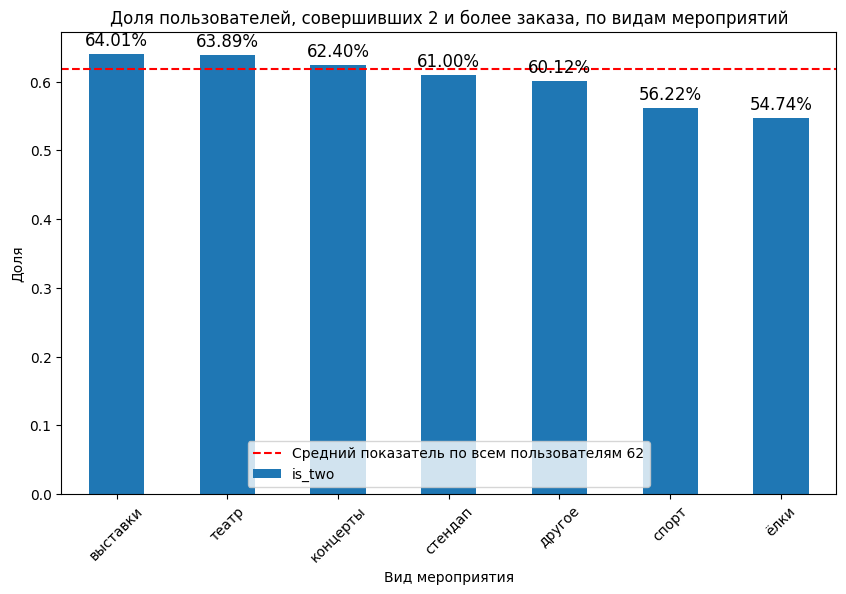

In [91]:
plt.figure(figsize=(10,6))
bar_container_412_1 = df_profile.groupby('genre')['is_two'].mean().sort_values(ascending=False).plot(kind='bar')
plt.axhline(y=df_profile['is_two'].mean(), color='r', linestyle='--', label=f'Средний показатель по всем пользователям {round(df_profile["is_two"].mean()*100)}')
plt.title('Доля пользователей, совершивших 2 и более заказа, по видам мероприятий')
plt.xlabel('Вид мероприятия')
plt.ylabel('Доля')
plt.xticks(rotation=45)
for i in bar_container_412_1.patches:
    bar_container_412_1.annotate(f'{i.get_height():.2%}',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(0, 3),
                                textcoords='offset points')
plt.legend(loc='lower center')
plt.show()

Теперь устройство, с которого совершалось бронирование.

In [52]:
df_profile.groupby('device')['is_two'].mean().sort_values(ascending=False)

device
desktop    0.642365
mobile     0.613182
Name: is_two, dtype: float64

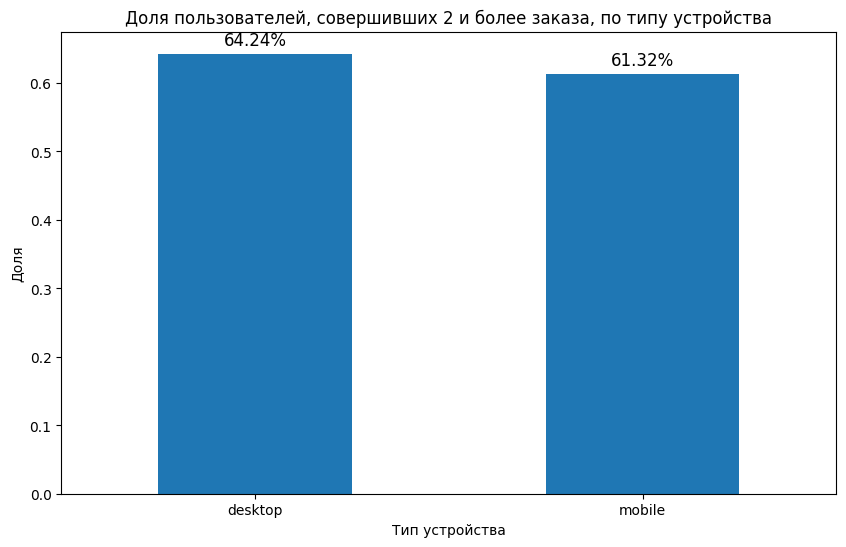

In [53]:
plt.figure(figsize=(10,6))
bar_container_412_2 = df_profile.groupby('device')['is_two'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Доля пользователей, совершивших 2 и более заказа, по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i in bar_container_412_2.patches:
    bar_container_412_2.annotate(f'{i.get_height():.2%}',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(0, 3),
                                textcoords='offset points')
plt.show()

Регион проведения мероприятия.

In [54]:
reg_based_returns = (df_profile.groupby('region').agg({'is_two':['mean','count']}).sort_values(by=('is_two','mean'),ascending=False))
display(reg_based_returns.loc[reg_based_returns[('is_two','count')] >= 100].head(10))
reg_based_returns_10 = reg_based_returns.loc[reg_based_returns[('is_two','count')] >= 100].head(10).reset_index()

is_two      
                          mean count
region                              
Шанырский регион      0.685658   509
Горицветская область  0.671875   256
Берёзовская область   0.663934   122
Заречная область      0.663551   214
Светополянский округ  0.663113   469
Речицкий регион       0.659898   197
Широковская область   0.651125  1244
Североярская область  0.642424  3795
Речиновская область   0.640271   442
Ветренский регион     0.638158   152

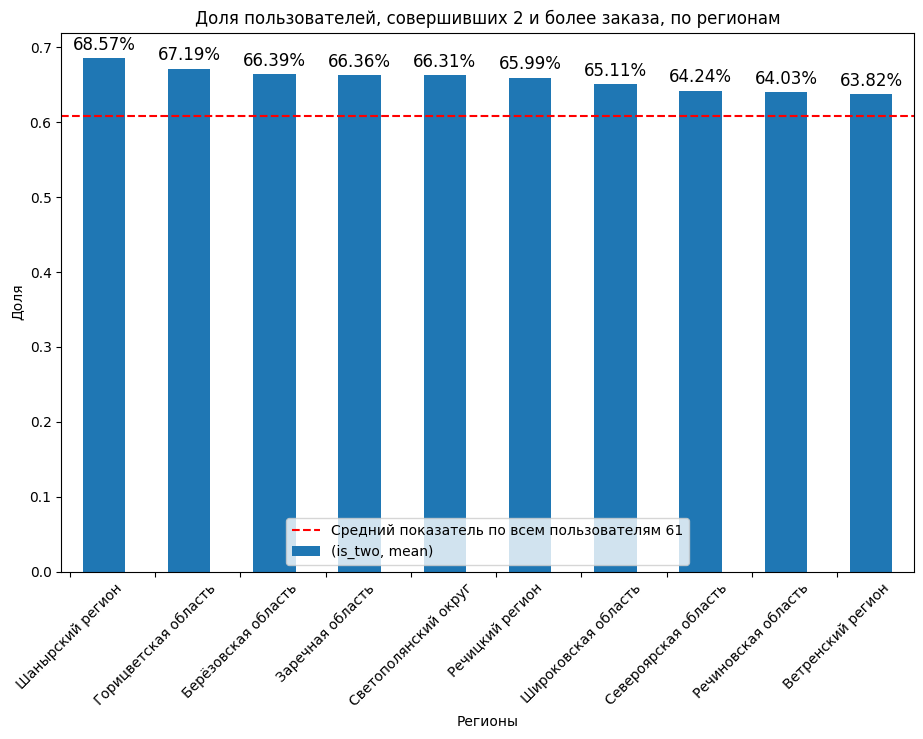

In [55]:
bar_container_412_3_temp = reg_based_returns.loc[reg_based_returns[('is_two','count')] >= 100]
bar_container_412_3 = bar_container_412_3_temp.head(10).plot(kind='bar', y=('is_two','mean'),figsize=(11,7), legend=True)
plt.axhline(y=bar_container_412_3_temp[('is_two','mean')].mean(), color='r', linestyle='--', label=f'Средний показатель по всем пользователям {round(bar_container_412_3_temp[("is_two","mean")].mean()*100)}')
plt.title('Доля пользователей, совершивших 2 и более заказа, по регионам')
plt.xlabel('Регионы')
plt.ylabel('Доля')
plt.xticks(rotation=45)
locs, labels = plt.xticks()
plt.xticks(locs - 0.4, labels)
for i in bar_container_412_3.patches:
    bar_container_412_3.annotate(f'{i.get_height():.2%}',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(0, 3),
                                textcoords='offset points')
plt.legend(loc='lower center')
plt.show()

Билетные операторы:

In [56]:
service_based_returns = df_profile.groupby('service').agg({'is_two':['mean','count']}).sort_values(by=('is_two','mean'),ascending=False)
display(service_based_returns.loc[service_based_returns[('is_two','count')] >= 100].head(10))
service_based_returns_10 = service_based_returns.loc[service_based_returns[('is_two','count')] >= 100].head(10).reset_index()

is_two      
                    mean count
service                       
Show_ticket     0.660819   171
Край билетов    0.655844   462
Дом культуры    0.647887   355
Мир касс        0.647343   207
Весь в билетах  0.636364  1320
Билеты в руки   0.632006  2587
Прачечная       0.630068   592
Облачко         0.616856  2195
Лови билет!     0.616193  2853
Мой билет       0.613832  3022

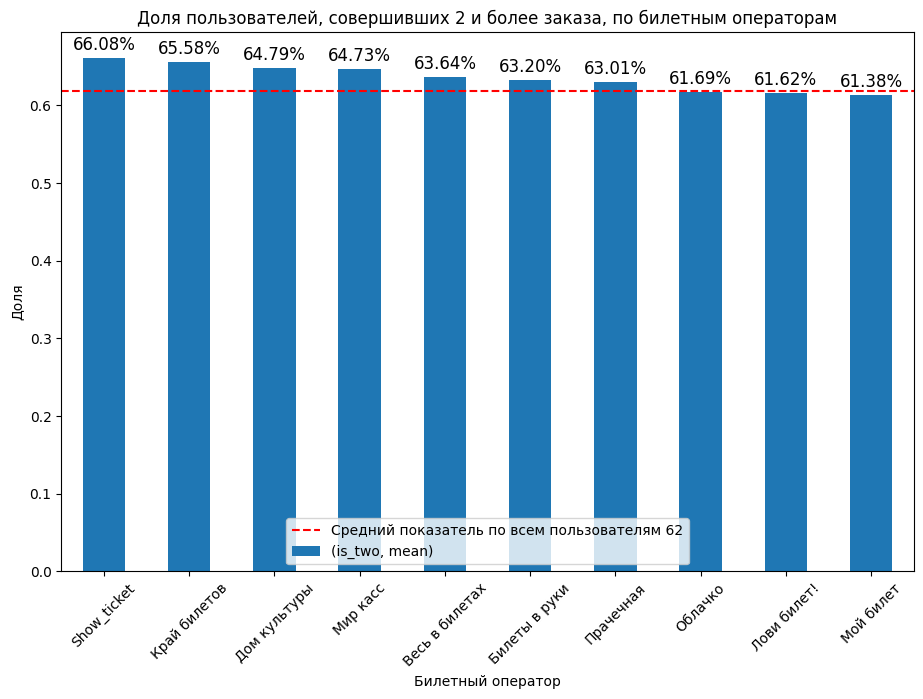

In [57]:
bar_container_412_1_temp = service_based_returns.loc[service_based_returns[('is_two','count')] >= 100]
bar_container_412_1 = bar_container_412_1_temp.head(10).plot(kind='bar', y=('is_two','mean'), legend=True, figsize=(11,7))
plt.axhline(y=bar_container_412_1_temp[('is_two','mean')].mean(), color='r', linestyle='--', label=f'Средний показатель по всем пользователям {round(bar_container_412_1_temp[("is_two","mean")].mean()*100)}')
plt.title('Доля пользователей, совершивших 2 и более заказа, по билетным операторам')
plt.xlabel('Билетный оператор')
plt.ylabel('Доля')
plt.xticks(rotation=45)
for i in bar_container_412_1.patches:
    bar_container_412_1.annotate(f'{i.get_height():.2%}',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(0, 3),
                                textcoords='offset points')
plt.legend(loc='lower center')
plt.show()

Посмотрим, сколько пересечений в топ 10 регионах по первой покупке и топ 10 по возврату:

In [58]:
display(len(set(most_wanted_region_10['region']) & set(reg_based_returns_10['region'])))

5

Теперь по билетным операторам:

In [59]:
display(len(set(most_wanted_service_10['service']) & set(service_based_returns_10['service'])))

8

- По видам мероприятий чаще всего возвращаются посетители выставок и театров (64%), реже всего посетители елок (55%).  
- Пользователи ПК возвращаются чаще мобильных (64% против 61%). При этом важно помнить о распределении пользователей (83% mobile против 17% desktop). У сильно более популярной категории всегда будет больше случайных клиентов.
- У ТОП-10 регионов идёт плавное падение с 69 до 64%, явного лидера нет, при этом 5 регионов совпадают со списом из прошлого пункта с наиболее посещаемыми регионами.  
- По площадкам ситуация аналогичная, плавное падение с 66 до 61% без явного лидера, но из ТОП 10 операторов первой покупки к 8 клиенты вернулись повторно.
- Ни в одном из сегментов не было ярко выраженного лидера.

---

**Пункт 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы от заказчика:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

- Гиппотеза 1. 56% пользователей, купивших билет на спортивное мероприятие,  возвращаются за второй покупкой, данный показатель ниже только у посетителей елок (55%). Гиппотеза неверна - спортивные мероприятия не в топе, отрыва 1го места в рейтинге типов от других также не наблюдается.
- Гиппотеза 2. Мы видим совпадение 5 регионов из 10, что может свидетельствовать о наличии такой связи.

#### Промежуточный вывод к разделу 4.1
На основании проведённого анализа можно заключить, что характеристики первого заказа чаще не оказывают существенного влияния на вероятность возвращения пользователя.
Различия по категориям мероприятий, устройствам присутствуют, но они не носят системного характера и не объясняют закономерно различия в удержании. Большое количество повторений билетных операторов требует дальнейшего уточнения в разрезе разнообразия видов мероприятий, на которые доступны билеты - необходимо понять, это вопрос лояльности или просто у этих операторов доступных билетов больше. Также по регионам необходима дальнейшая проработка с точки зрения колчества мероприятий в этих регионах для того, чтобы разделить лояльность и просто большие регионы с гораздо большим (по сравнению с остальными) количеством мероприятий.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Пункт 4.2.1.** Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

- Построим сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответим на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

---


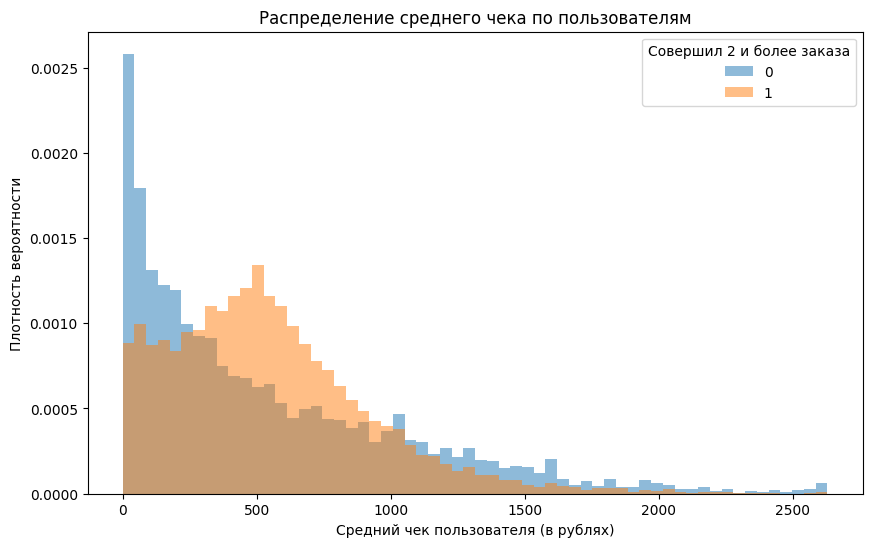

In [60]:
plt.figure(figsize=(10,6))
for i in df_profile['is_two'].unique():
    df_profile.loc[df_profile['is_two'] == i,  'avg_revenue_per_order'].plot(kind='hist',bins=60,density=True, alpha=0.5, label=f'{i}',legend=True)
plt.title('Распределение среднего чека по пользователям')
plt.xlabel('Средний чек пользователя (в рублях)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Совершил 2 и более заказа')
plt.show()

In [61]:
display('Статистика среднего чека по пользователям, не совершившим 2 и более заказа:')
display(df_profile.loc[df_profile['is_two'] == 0,  'avg_revenue_per_order'].describe())
display('Статистика среднего чека по пользователям, совершившим 2 и более заказа:')
display(df_profile.loc[df_profile['is_two'] == 1,  'avg_revenue_per_order'].describe())

'Статистика среднего чека по пользователям, не совершившим 2 и более заказа:'

count    8303.000000
mean      542.044622
std       514.759087
min         0.000000
25%       132.100000
50%       376.330000
75%       823.970000
max      2628.420000
Name: avg_revenue_per_order, dtype: float64

'Статистика среднего чека по пользователям, совершившим 2 и более заказа:'

count    13535.000000
mean       546.865890
std        371.369274
min          0.000000
25%        275.237500
50%        498.532857
75%        741.760294
max       2628.420000
Name: avg_revenue_per_order, dtype: float64

Средние значения покупок совпадают. Разница по медиане заметна: одиночные покупки - 376 руб., с 2мя и более заказами - 500 руб. Это говорит о том, что при исключении выбросов покупатели с 2мя и более заказами действительно тратят на ~30% больше, то есть характеризуются более стабильным и умеренно выскоим чеком.

---

**Пункт 4.2.2.** Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответим на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


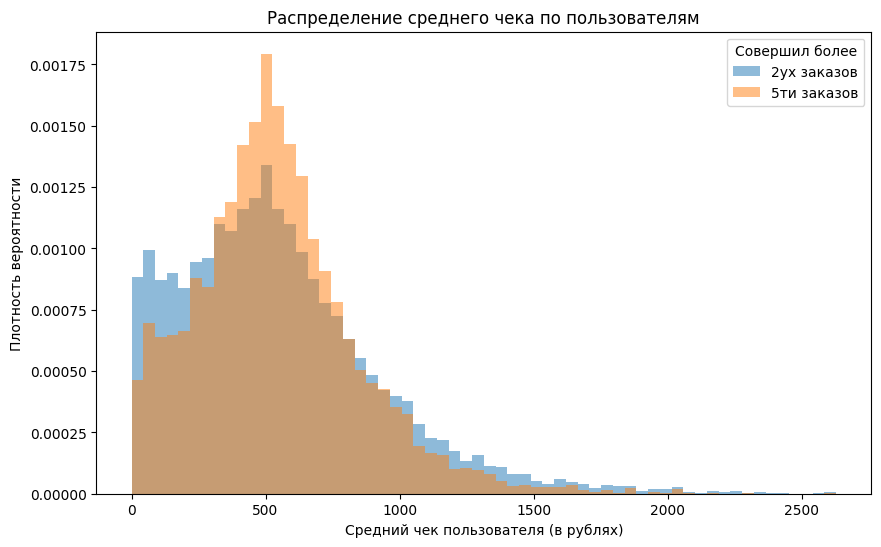

In [62]:
plt.figure(figsize=(10,6))
df_profile.loc[df_profile['is_two'] == 1,  'avg_revenue_per_order'].plot(kind='hist',bins=60,density=True, alpha=0.5, label=f'2ух заказов',legend=True)
df_profile.loc[df_profile['is_five'] == 1,  'avg_revenue_per_order'].plot(kind='hist',bins=60,density=True, alpha=0.5, label=f'5ти заказов',legend=True)
plt.title('Распределение среднего чека по пользователям')
plt.xlabel('Средний чек пользователя (в рублях)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Совершил более')
plt.show()

In [63]:
display('Статистика среднего чека по пользователям, совершившим 2 и более заказа:')
display(df_profile.loc[df_profile['is_two'] == 1,  'avg_revenue_per_order'].describe())
display('Статистика среднего чека по пользователям, совершившим 5 и более заказов:')
display(df_profile.loc[df_profile['is_five'] == 1,  'avg_revenue_per_order'].describe())

'Статистика среднего чека по пользователям, совершившим 2 и более заказа:'

count    13535.000000
mean       546.865890
std        371.369274
min          0.000000
25%        275.237500
50%        498.532857
75%        741.760294
max       2628.420000
Name: avg_revenue_per_order, dtype: float64

'Статистика среднего чека по пользователям, совершившим 5 и более заказов:'

count    6400.000000
mean      540.862062
std       303.009098
min         0.000000
25%       340.324554
50%       515.541667
75%       696.724276
max      2628.420000
Name: avg_revenue_per_order, dtype: float64

Средние чеки, медиана у обеих групп очень близки, стандартное отклонение ниже (примерно на 20%) у пользователей, совершивших 5 и более заказов. Таким образом получается, что средний чек не растет по мере роста количества заказов и работать нужно с удержанием, а не повышением среднего чека.

---

**Пункт 4.2.3.** Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучим распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишем основные наблюдения.
- Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответим на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
---

In [64]:
df_profile['avg_tickets'].describe()

count    21924.000000
mean         2.751419
std          0.907977
min          1.000000
25%          2.000000
50%          2.757464
75%          3.125000
max          6.000000
Name: avg_tickets, dtype: float64

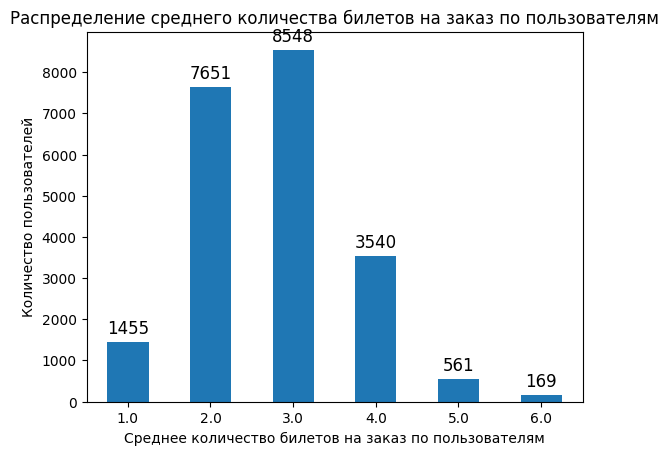

In [65]:
bar_container_423_1 = df_profile['avg_tickets'].round().value_counts().sort_index().plot(kind='bar')
plt.title('Распределение среднего количества билетов на заказ по пользователям')
plt.xlabel('Среднее количество билетов на заказ по пользователям')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
for i in bar_container_423_1.patches:
    bar_container_423_1 .annotate(f'{int(i.get_height())}',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(0, 3),
                                textcoords='offset points')
plt.show()

In [66]:
df_profile['ticket_group'] = pd.cut(df_profile['avg_tickets'], bins=[0,2,3,5,np.inf], labels=['1-2','2-3','3-5','5-'])
df_423 = df_profile.groupby('ticket_group').agg({'user_id':'count','is_two':['sum','mean'],'is_five':['sum','mean']}).reset_index()
df_423[('is_two','mean')] = df_423[('is_two','mean')].apply(lambda x: f"{x:.2%}")
df_423[('is_five','mean')] = df_423[('is_five','mean')].apply(lambda x: f"{x:.2%}")
display(df_423)


C:\Users\kasya\AppData\Local\Temp\ipykernel_33932\1072946759.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_423 = df_profile.groupby('ticket_group').agg({'user_id':'count','is_two':['sum','mean'],'is_five':['sum','mean']}).reset_index()


ticket_group user_id is_two         is_five        
                 count    sum    mean     sum    mean
0          1-2    6123   2454  40.08%     570   9.31%
1          2-3   10101   7553  74.77%    4266  42.23%
2          3-5    5508   3492  63.40%    1554  28.21%
3           5-     192     59  30.73%      10   5.21%

Пользователи распределены по сегментам неравномерно - сконцентрированы в сегменте 2-3 билета на заказ: около 75 % совершают как минимум два заказа, и более 42 % - пять и более заказов, выраженных аномалий нет.

#### Промежуточный вывод к разделу 4.2
Результаты анализа показывают, что количественные характеристики заказов действительно умеренно связаны с вовлечённостью пользователей:
- Средний чек. Пользователи, совершающие повторные покупки, характеризуются более высоким медианным чеком (500 руб. против 376), однако по мере роста заказов средний чек не увеличивается.
- Количество билетов в заказе: пользователи чаще всего приобретают ~3 билета за заказ, и именно этот сегмент демонстрирует наибольшую долю возвращающихся клиентов.
- Поведение пользователей в части состава и стоимости заказов достаточно стабильно

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Пункт 4.3.1.** Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделим день недели.
- Для каждого дня недели подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируем.
- Ответим на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [67]:
df_profile['day_of_week'] = df_profile['first_order_dt'].dt.day_name()
df_orders_by_dow = df_profile.groupby('day_of_week').agg({'user_id':'count','is_two':['sum','mean'],'is_five':['sum','mean']}).sort_values(by=[('is_two','mean'),('is_five','mean')], ascending=False)
df_orders_by_dow_1 = df_orders_by_dow.copy()
df_orders_by_dow_1[('is_two','mean')] = df_orders_by_dow[('is_two','mean')].apply(lambda x: f"{x:.2%}")
df_orders_by_dow_1[('is_five','mean')] = df_orders_by_dow[('is_five','mean')].apply(lambda x: f"{x:.2%}")
display(df_orders_by_dow_1)

user_id is_two         is_five        
              count    sum    mean     sum    mean
day_of_week                                       
Saturday       3461   2219  64.11%    1123  32.45%
Monday         2947   1868  63.39%     892  30.27%
Wednesday      3084   1927  62.48%     862  27.95%
Tuesday        3218   2010  62.46%     991  30.80%
Sunday         2819   1708  60.59%     828  29.37%
Friday         3274   1962  59.93%     877  26.79%
Thursday       3130   1865  59.58%     827  26.42%

In [68]:
df_orders_by_dow[('is_two','mean')] = df_orders_by_dow[('is_two','mean')].apply(lambda x: round(x*100))
df_orders_by_dow[('is_five','mean')] = df_orders_by_dow[('is_five','mean')].apply(lambda x: round(x*100))

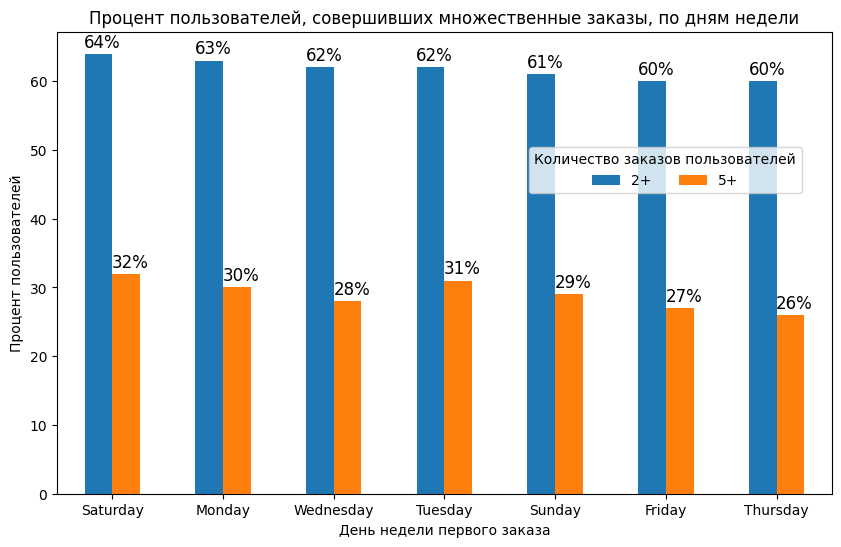

In [69]:
bar_container_431_1 = df_orders_by_dow.plot(kind='bar',y=[('is_two','mean'),('is_five','mean')], figsize=(10,6))
plt.title('Процент пользователей, совершивших множественные заказы, по дням недели')
plt.xlabel('День недели первого заказа')
plt.ylabel('Процент пользователей')
plt.legend(['2+','5+'],title='Количество заказов пользователей', loc='center left', bbox_to_anchor=(0.6, 0.7), ncol=2)
plt.xticks(rotation=0)
for i in bar_container_431_1.patches:
    bar_container_431_1.annotate(f'{i.get_height()}%',
                                (i.get_x() + i.get_width() / 2, i.get_height()),
                                ha='center', va='bottom',
                                fontsize=12,
                                xytext=(3, 2),
                                textcoords='offset points')
plt.show()

С самой высокой долей вероятности вернутся пользователи, совершившие первый заказ в субботу. При этом на втором месте у пользователей с 2+ заказами идёт понедельник, а у пользователей с 5+ заказами — вторник.

---

**Пункт 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа, и сделаем выводы.

---


In [70]:
df_profile['is_two-four'] = df_profile['total_orders'].apply(lambda x: 1 if 2 <= x <=4 else 0)

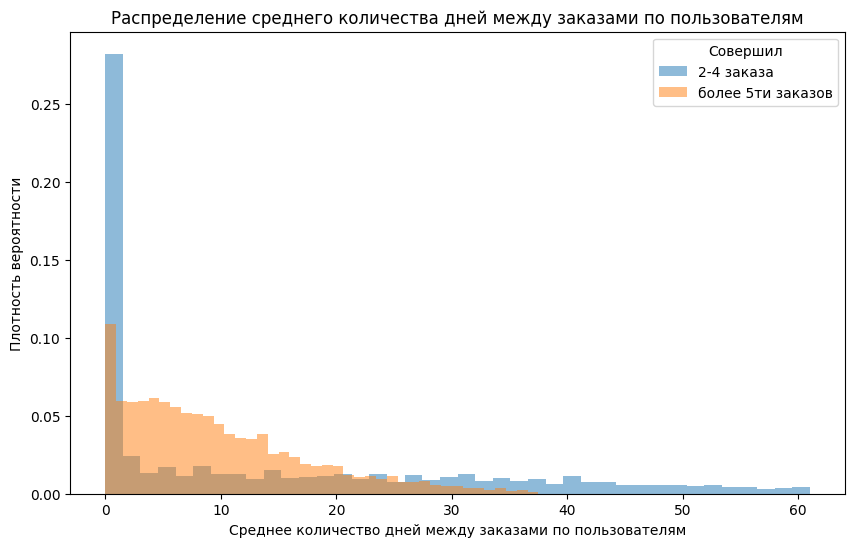

In [71]:
plt.figure(figsize=(10,6))
df_profile.loc[df_profile['is_two-four'] == 1,  'avg_days_between_orders'].plot(kind='hist',bins=40,density=True, alpha=0.5, label=f'2-4 заказа',legend=True)
df_profile.loc[df_profile['is_five'] == 1,  'avg_days_between_orders'].plot(kind='hist',bins=40,density=True, alpha=0.5, label=f'более 5ти заказов',legend=True)
plt.title('Распределение среднего количества дней между заказами по пользователям')
plt.xlabel('Среднее количество дней между заказами по пользователям')
plt.ylabel('Плотность вероятности')
plt.legend(title='Совершил')
plt.show()

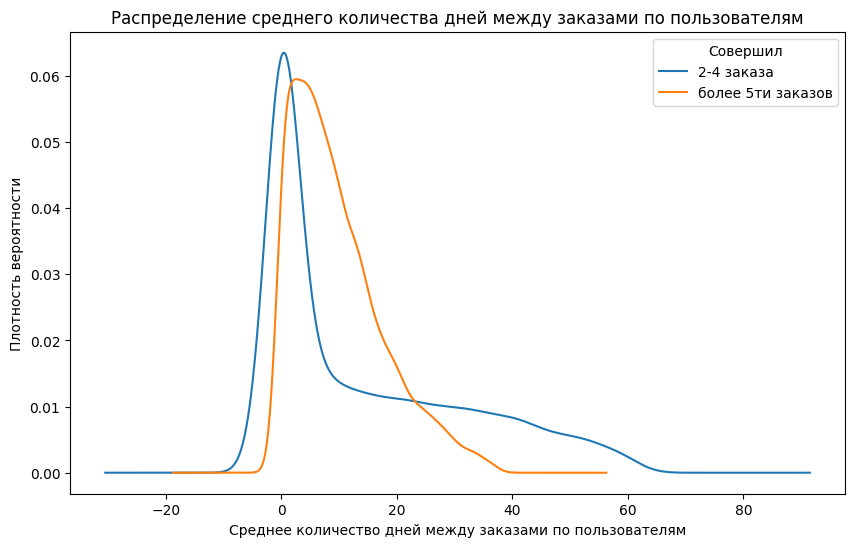

In [72]:
plt.figure(figsize=(10,6))
df_profile.loc[df_profile['is_two-four'] == 1,  'avg_days_between_orders'].plot(kind='kde', label=f'2-4 заказа',legend=True)
df_profile.loc[df_profile['is_five'] == 1,  'avg_days_between_orders'].plot(kind='kde', label=f'более 5ти заказов',legend=True)
plt.title('Распределение среднего количества дней между заказами по пользователям')
plt.xlabel('Среднее количество дней между заказами по пользователям')
plt.ylabel('Плотность вероятности')
plt.legend(title='Совершил')
plt.show()

In [73]:
display(df_profile.loc[df_profile['is_two-four'] == 1,  'avg_days_between_orders'].describe())
display(df_profile.loc[df_profile['is_five'] == 1,  'avg_days_between_orders'].describe())

count    6484.000000
mean       14.118008
std        17.210437
min         0.000000
25%         0.000000
50%         5.333333
75%        26.000000
max        61.000000
Name: avg_days_between_orders, dtype: float64

count    6400.000000
mean        9.636372
std         7.898397
min         0.000000
25%         3.427198
50%         7.833333
75%        13.891667
max        37.500000
Name: avg_days_between_orders, dtype: float64

Более активные пользователи (5+) делают новые заказы чаще, чем пользователи с меньшей активностью (10 дней между заказами против 14). При этом у них более стабильный и предсказуемый интервал между покупками (меньший разброс значений - 8 против 17).

#### Промежуточный вывод к разделу 4.3
Результаты анализа временных признаков подтверждают, что время первой покупки и интервалы между заказами оказывают влияние на возврат пользователей.
- Наибольшая вероятность повторного заказа наблюдается у пользователей, совершивших первую покупку в субботу, второе и третье места занимают понедельник и вторник.
- Пользователи, совершившие 5 и более заказов, делают новые покупки чаще, чем менее активные (2–4 заказа). При этом у них ниже разброс значений, что говорит о формировании устойчивой привычки к регулярным покупкам и более высокой лояльности.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используем универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Пункт 4.4.1:** Проведем корреляционный анализ:
- Рассчитаем коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`).
- Проанализируем полученные результаты.
- Визуализируем результат корреляции с помощью тепловой карты.
- Ответим на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [74]:
corr_matrix_1 = df_profile.drop(columns=['user_id']).phik_matrix(interval_cols=['total_orders','avg_revenue_per_order','avg_tickets','avg_days_between_orders'])
#display(df_profile)
display(corr_matrix_1.loc[corr_matrix_1.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False))

,total_orders
is_five,1.000000
avg_days_between_orders,0.639791
is_two,0.618740
is_two-four,0.548321
last_order_dt,0.393667
first_order_dt,0.388741
avg_tickets,0.375586
ticket_group,0.259424
avg_revenue_per_order,0.246708
service,0.040299


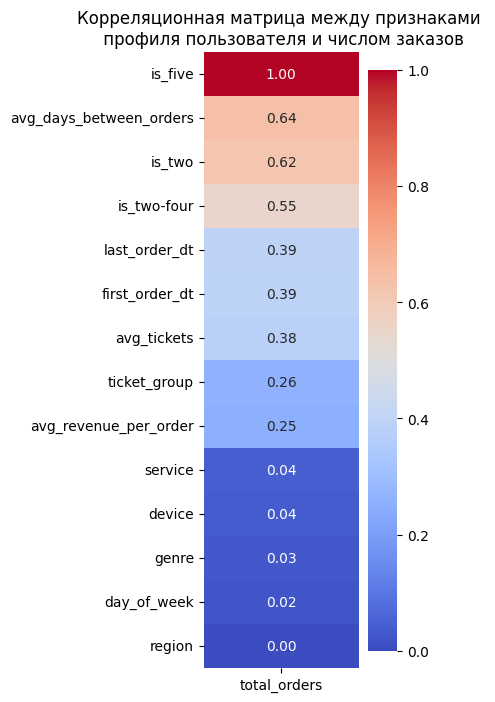

In [75]:
plt.figure(figsize=(2.5,8))
sns.heatmap(corr_matrix_1.loc[corr_matrix_1.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица между признаками \n профиля пользователя и числом заказов')
plt.show()

Посмотрим на графиках умеренную связь (0.3-0.7). Здесь и далее корреляция у бинарных столбцов `is_two`,`is_two-four` и `is_five` будет сознательно игнорироваться, так как они рассчитываются от целевого признака `total_orders`.

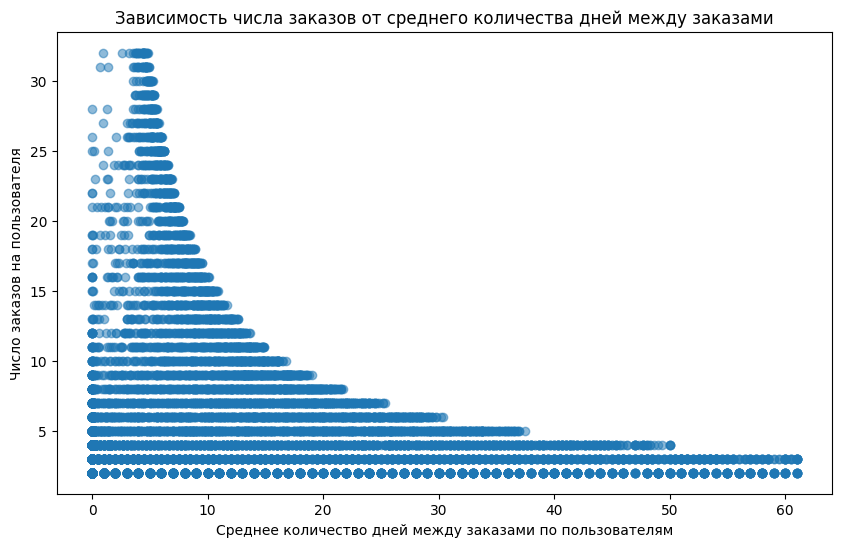

In [76]:
plt.figure(figsize=(10,6))
plt.plot(df_profile['avg_days_between_orders'], df_profile['total_orders'], 'o', alpha=0.5)
plt.title('Зависимость числа заказов от среднего количества дней между заказами')
plt.xlabel('Среднее количество дней между заказами по пользователям')
plt.ylabel('Число заказов на пользователя')
plt.show()

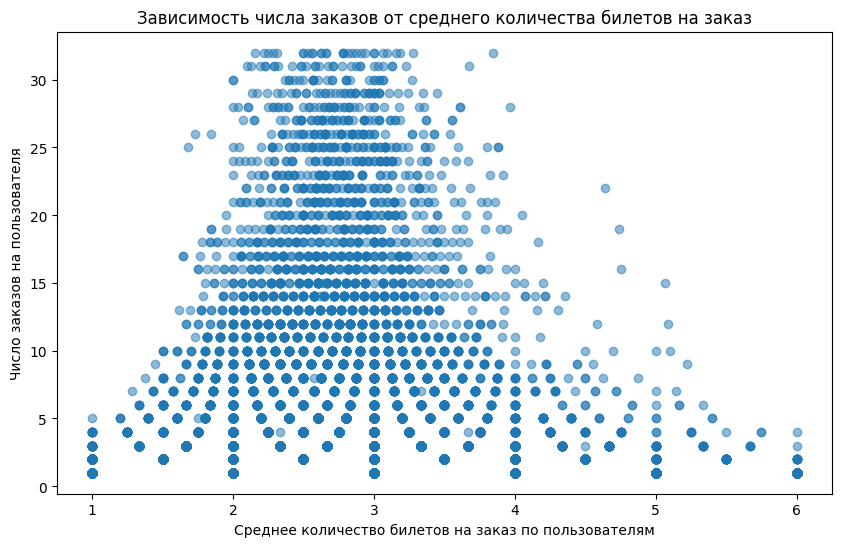

In [77]:
plt.figure(figsize=(10,6))
plt.plot(df_profile['avg_tickets'], df_profile['total_orders'], 'o', alpha=0.5)
plt.title('Зависимость числа заказов от среднего количества билетов на заказ')
plt.xlabel('Среднее количество билетов на заказ по пользователям')
plt.ylabel('Число заказов на пользователя')
plt.show()

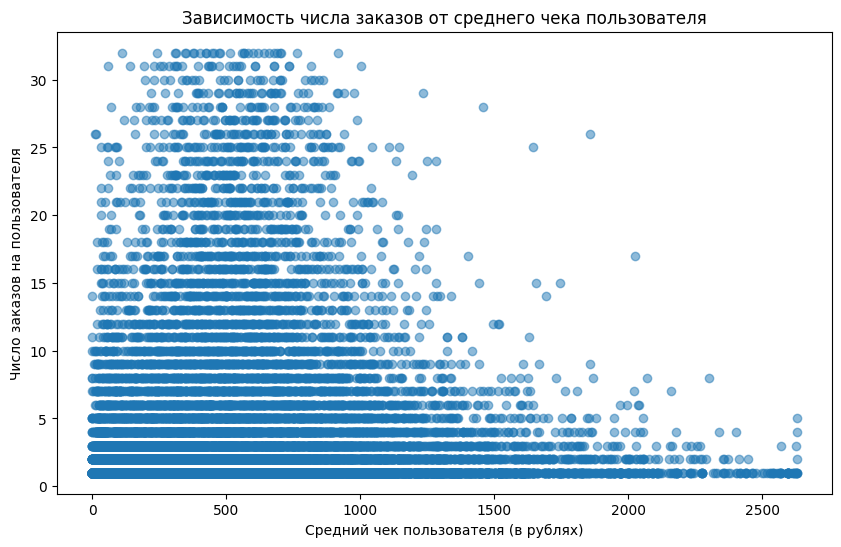

In [78]:
plt.figure(figsize=(10,6))
plt.plot(df_profile['avg_revenue_per_order'], df_profile['total_orders'], 'o', alpha=0.5)
plt.title('Зависимость числа заказов от среднего чека пользователя')
plt.xlabel('Средний чек пользователя (в рублях)')
plt.ylabel('Число заказов на пользователя')
plt.show()

На графиках видно, что по мере увеличения числа заказов пользователей разброс среднего количества дней между заказами, среднего чека и среднего числа билетов на заказ уменьшается.
Это говорит о том, что активные пользователи демонстрируют более стабильное и предсказуемое поведение: они совершают заказы с примерно одинаковыми интервалами и приобретают схожие объемы билетов.
Менее активные пользователи, напротив, характеризуются большей вариативностью — кто-то делает заказы часто, кто-то с большими перерывами, а объем заказов у них также значительно колеблется.

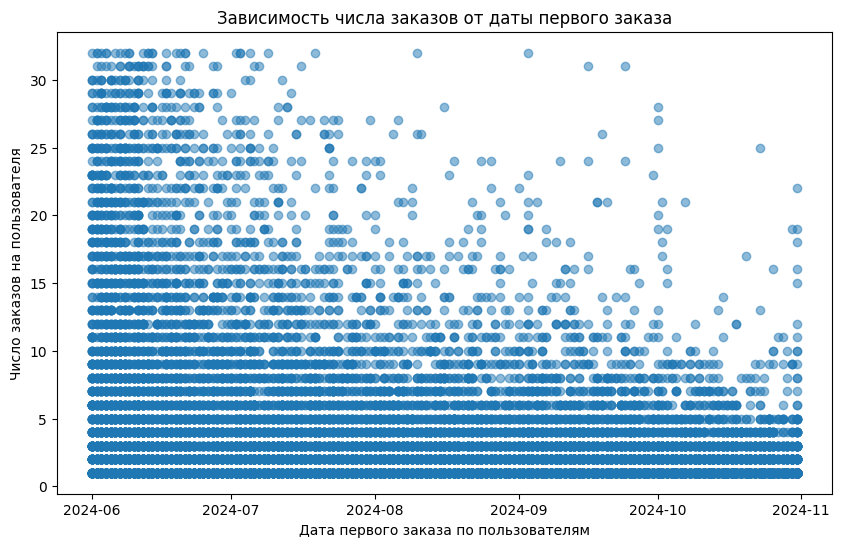

In [79]:
plt.figure(figsize=(10,6))
plt.plot(df_profile['first_order_dt'], df_profile['total_orders'], 'o', alpha=0.5)
plt.title('Зависимость числа заказов от даты первого заказа')
plt.xlabel('Дата первого заказа по пользователям')
plt.ylabel('Число заказов на пользователя')
plt.show()

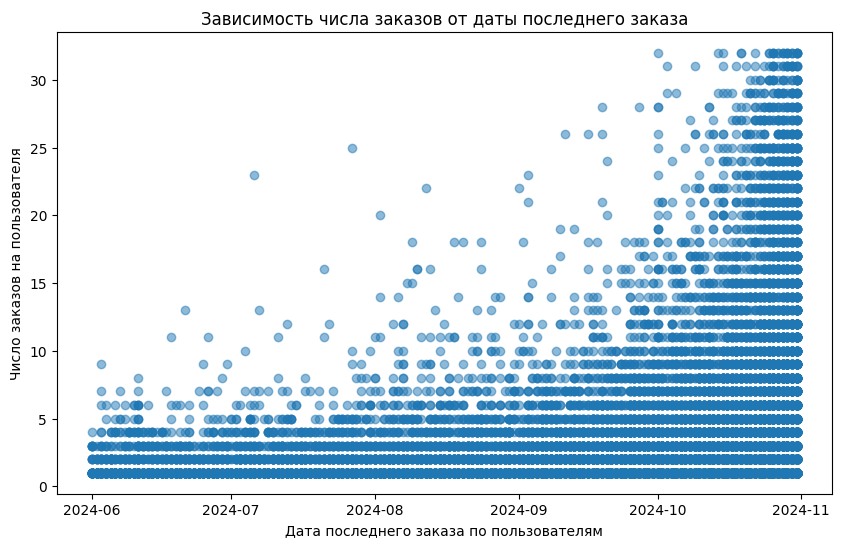

In [80]:
plt.figure(figsize=(10,6))
plt.plot(df_profile['last_order_dt'], df_profile['total_orders'], 'o', alpha=0.5)
plt.title('Зависимость числа заказов от даты последнего заказа')
plt.xlabel('Дата последнего заказа по пользователям')
plt.ylabel('Число заказов на пользователя')
plt.show()

Мы видим зависимость между количеством заказов и датами первого и последнего заказов, но она связана с тем, что выгрузка данных охватывает определённый период времени, а не определенный массив пользователей, поэтому на эти зависимости не стоит опираться.

Выделим сегменты пользователей по полю `total_orders`, а затем повторим корреляционный анализ. Выделим такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.

In [81]:
df_profile['tot_orders_segments'] = pd.cut(df_profile['total_orders'], bins=[0,1,4,np.inf], labels=['1','2-4','5-'])
corr_matrix_2 = df_profile.drop(columns=['user_id','total_orders']).phik_matrix(interval_cols=['avg_revenue_per_order','avg_tickets','avg_days_between_orders'])
#display(df_profile)


In [82]:
display(corr_matrix_2.loc[corr_matrix_2.index != 'tot_orders_segments'][['tot_orders_segments']].sort_values(by='tot_orders_segments', ascending=False))

,tot_orders_segments
is_five,1.000000
is_two,1.000000
is_two-four,0.999990
avg_tickets,0.570884
last_order_dt,0.560144
first_order_dt,0.527300
avg_days_between_orders,0.482301
avg_revenue_per_order,0.292750
ticket_group,0.236131
region,0.105754


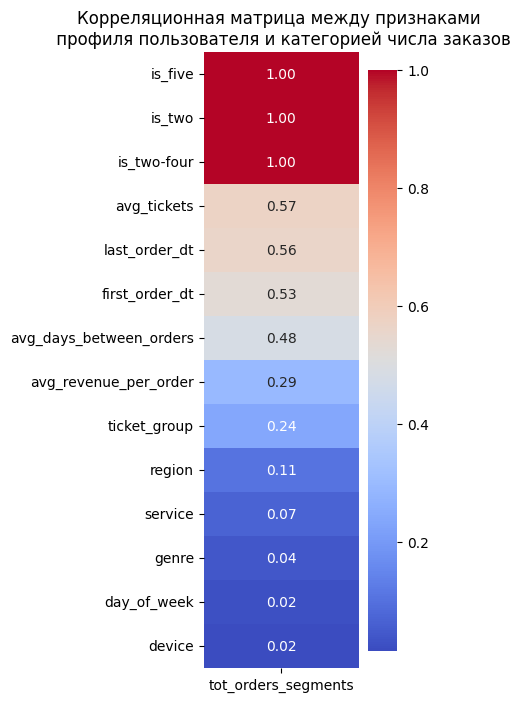

In [83]:
plt.figure(figsize=(2.5,8))
sns.heatmap(corr_matrix_2.loc[corr_matrix_2.index != 'tot_orders_segments'][['tot_orders_segments']].sort_values(by='tot_orders_segments', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица между признаками \n профиля пользователя и категорией числа заказов')
plt.show()

В целом, выводы схожие, из важного видим умеренную связь с средним количеством билетов в заказах, суммой заказа и количеством дней между заказами.

#### Промежуточный вывод к разделу 4.4
Результаты корреляционного анализа показали, что число заказов пользователей имеет слабую прямую зависимость от категориальных признаков (типа первого события, устройства или региона), но умеренную связь с поведенческими и количественными характеристиками заказов.
Наиболее связанные признаки:
- средний интервал между заказами;
- среднее количество билетов в заказе;
- средняя выручка с заказа.
Эти метрики показывают, что по мере роста числа заказов пользователи демонстрируют всё более стабильное и предсказуемое поведение: они делают заказы с похожими интервалами, тратят сопоставимые суммы на сопоставимое количество билетов.

In [90]:
df_profile[df_profile['is_five'] == 1].describe()

,first_order_dt,last_order_dt,total_orders,avg_revenue_per_order,avg_tickets,avg_days_between_orders,is_two,is_five,is_two-four
count,6400,6400,5331.000000,6400.000000,6400.000000,6400.000000,6400.0,6400.0,6400.0
mean,2024-07-08 13:47:19.499999744,2024-10-14 03:07:39,10.887451,540.862062,2.744131,9.636372,1.0,1.0,0.0
min,2024-06-01 00:00:00,2024-06-03 00:00:00,5.000000,0.000000,1.000000,0.000000,1.0,1.0,0.0
25%,2024-06-07 00:00:00,2024-10-10 00:00:00,6.000000,340.324554,2.400000,3.427198,1.0,1.0,0.0
50%,2024-06-23 00:00:00,2024-10-23 00:00:00,8.000000,515.541667,2.727273,7.833333,1.0,1.0,0.0
75%,2024-07-31 00:00:00,2024-10-29 00:00:00,14.000000,696.724276,3.000000,13.891667,1.0,1.0,0.0
max,2024-10-31 00:00:00,2024-10-31 00:00:00,32.000000,2628.420000,5.400000,37.500000,1.0,1.0,0.0
std,NaN,NaN,6.543267,303.009098,0.532182,7.898397,0.0,0.0,0.0


### Промежуточный вывод по главе 4

Проведённый исследовательский анализ позволил выявить ключевые закономерности поведения пользователей и факторы, влияющие на их возвращение на платформу.

- Характеристики первого заказа в основном не оказывают существенного влияния на вероятность повторной покупки. Поведение пользователей в дальнейшем определяется не первоначальными условиями, а их последующей активностью. В рамках раздела 4.1 мы обнаружили определенные повторения в рамках региона и оператора, которые не подтвердились в разделе 4.4. Это требует дальнейшей проработки.
- Количественные признаки заказов (средний чек, количество билетов, частота заказов) лучше отражают уровень вовлечённости.
- Временные характеристики показывают влияние на возвращаемость: пользователи, совершающие первые заказы в выходные (особенно в субботу), возвращаются чаще. Клиенты с 5 и более заказами делают покупки примерно вдвое чаще и демонстрируют меньший разброс интервалов между заказами — что свидетельствует о сформировавшейся привычке.
- Корреляционный анализ подтвердил, что ключевыми факторами удержания являются поведенческие метрики. С ростом числа заказов пользователи становятся более предсказуемыми и стабильными: их покупки происходят с регулярными интервалами, с сопоставимыми суммами и числом билетов.
  
Портрет лояльного пользователя: в среднем 11 заказов, со средней выручкой 540 рублей за 2.7 билета, новая покупка совершается примерно раз в 10 дней, первый заказ был совершен в субботу.

### 5. Общий вывод и рекомендации


**Информацию о данных**:  
Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о бронировании билетов Яндекс.Афиша. Были пересчитаны суммы заказов в рубли, оптимизирована размерность столбцов. В рамках фильтрации оставили значения в `revenue_rub` и `tickets_count` по 99 перцентилю, всего было удалено 188 значений в `tickets_count` (0.07% от общего числа), 3206 значений в `revenue_rub` (1.1%). После формирования профиля пользователей с основными характеристиками и признаками лояльности дополнительно отфильтровали 1069 значений по столбцу `total_orders` и 675 значений по столбцу `avg_days_between_orders`.

Построили профиль пользователей с основными характеристиками и признаками лояльности в датафрейме df_profile.

- `first_order_dt` дата первого заказа;
- `last_order_dt` дата последнего заказа;
- `device` устройство, с которого был сделан первый заказ;
- `region` регион, в котором был сделан первый заказ;
- `service` билетного партнёра, к которому обращались при первом заказе;
- `genre` жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- `total_orders` общее количество заказов;
- `avg_revenue_per_order` средняя выручка с одного заказа в рублях;
- `avg_tickets` среднее количество билетов в заказе;
- `avg_days_between_orders` среднее время между заказами.
- `is_two` совершил ли пользователь 2 и более заказа;
- `is_five` совершил ли пользователь 5 и более заказов;
- `ticket_group` сегменты пользователей по среднему количеству билетов в заказе (от 1 до 2 билетов/от 2 до 3 билетов/от 3 до 5 билетов/от 5 и более билетов;
- `day_of_week` день недели совершения 1го заказа;
- `is_two-four` совершил ли пользователь 2 - 4 заказа;
- `tot_orders_segments` сегменты пользователей по кол-ву заказов(1 заказ/от 2 до 4 заказов/от 5 и выше).

**Основные результаты анализа.**  
  
- После очистки и предобработки в итоговом датасете осталось 21 933 уникальных пользователя. 61,8 % пользователей совершают повторные покупки (2+ заказов), а 29,2 % относятся к активным и лояльным (5+ заказов). Средняя выручка с заказа составляет около 545 рублей, медианное количество билетов — 2.7, а средний интервал между покупками — около 16 дней.  
      
- Характеристики первого заказа, как правило, не оказывают значимого влияния на возврат. Определенные повторения в рамках региона и оператора, обнаруженные в разделе 4.1, требуют дальнейшей проработки.  
      
- Поведение возвращающихся пользователей отличается более высоким медианным чеком (≈500 рублей против 376 у однократных) и стабильным числом билетов — в среднем 2-3. Однако дальнейший рост среднего чека с увеличением числа заказов не наблюдается - пользователи стабилизируются в привычных рамках трат.  
      
- Наибольшая вероятность повторных покупок наблюдается у пользователей, впервые купивших билеты в субботу, а также у клиентов с короткими и стабильными интервалами между заказами (10 дней). Активные пользователи (5+) совершают новые заказы почти вдвое чаще, чем пользователи с 2–4 заказами, и показывают меньший разброс по интервалам.  
      
- Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа? 
       
- Категориальные признаки (регион, устройство, оператор) слабо связаны с числом заказов. Хорошую взаимосвязь показали количественные признаки: средний интервал между заказами, среднее количество билетов, средняя выручка на заказ. Это подтверждает, что поведенческие метрики отражают лояльность пользователей лучше любых категориальных характеристик.
  
Портрет лояльного пользователя: в среднем 11 заказов, со средней выручкой 540 рублей за 2.7 билета, новая покупка совершается примерно раз в 10 дней, первый заказ был совершен в субботу.
  
Рекомендации:  
- Для новых/неактивных клиентов сфокусироваться на формировании привычки покупки: удержание растёт по мере сокращения интервалов между заказами. Следует использовать механики повторного вовлечения, делая из случайных клиентов постоянных.
- Использовать модели прогнозирования лояльности, основанные на поведенческих метриках (частота, средний чек, билеты на заказ).
- Отслеживать динамику по активным пользователям и контролировать их удержание, как основного генератора прибыли.
- Провести дальнейшие углубленные исследования в части регионов и билетных операторов, в случае подтверждения взаимосвязи активнее взаимодействовать/проводить маркетинговые акции с операторами, которые одновременно генерируют и большое количество первичных клиентов, и высокий процент возврата. 




https://github.com/konstantin-kasyanov/project_module_2